In [20]:
import sys
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.image_list import ImageList
from torchvision.models.detection import rpn
from torchvision import transforms as T
from Modules import image_maker, shapes, colors

## Generating images

In [2]:
"""
Let's make an example 512 x 512 image
"""
canvas_size = (512, 512)
color_picker = colors.ColorPicker(
    colors.KNOWN_COLORS,
    colors.default_hls_settings
)

img_generator = image_maker.ImageMaker(image_shape=canvas_size,
                                       color_picker=color_picker,
                                       number_of_colors=4,
                                       shapes = [
                                           shapes.Triangle(),
                                           shapes.Circle(
                                               specifications={
                                                   'min_size': 80,
                                                   'max_size': 220
                                               }),
                                           shapes.Square(
                                               specifications={
                                                   'min_size': 35,
                                                   'max_size': 250
                                               })
                                       ],
                                      )

def make_image():
    image_meta = img_generator()
    image = image_maker.construct_image(image_meta)
    return image, image_meta

In [3]:
example_image, example_image_meta = make_image()

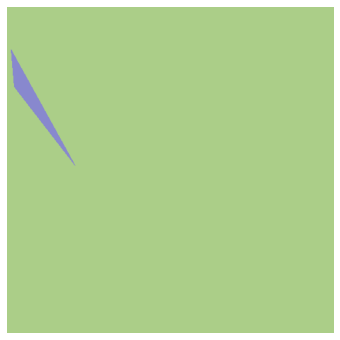

In [4]:
fig, ax = plt.subplots(figsize=(6,6))
ax.axis('off')
ax.imshow(example_image)

## Instantiating a pretrained model to create a feature map

In [5]:
model_repo = 'pytorch/vision:v0.10.1'

vgg16 = torch.hub.load(repo_or_dir=model_repo,
                       model='vgg16')
layer_count = 0
for layer in vgg16.children():
    layer_count += 1
print(f"vgg16 has {layer_count} layers")

Using cache found in /Users/carlosolivares/.cache/torch/hub/pytorch_vision_v0.10.1


vgg16 has 3 layers


Clearly the model has more than three layers. What actually happens is that they group the related steps together: 

In [6]:
"""
create the vgg16 based feature map creator
"""
n

print("COMPLETE VGG16 MODEL")
print(vgg16)
print("FEATURE MAP MAKER")
print(vgg16_featuremapper())

COMPLETE VGG16 MODEL
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, 

Using cache found in /Users/carlosolivares/.cache/torch/hub/pytorch_vision_v0.10.1
/Users/carlosolivares/opt/anaconda3/envs/basic-pytorch/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/Users/carlosolivares/opt/anaconda3/envs/basic-pytorch/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## making a feature map to pass to the backbone

In [7]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

standard_transform = T.Compose(
    [
        T.ToTensor(),
        normalize,
    ]
)

In [8]:
feature_mapper = vgg16_featuremapper()
image_for_input = standard_transform(example_image)
feature_map = feature_mapper(image_for_input)

Using cache found in /Users/carlosolivares/.cache/torch/hub/pytorch_vision_v0.10.1


In [9]:
print(f"The feature map has shape {feature_map.shape}")

The feature map has shape torch.Size([512, 16, 16])


In [10]:
"""
Putting all of this in an ImageList 
"""

image_list = ImageList(tensors=image_for_input, image_sizes=[(512,512)])

In [11]:
anchor_generator = AnchorGenerator()

In [12]:
anchor_generator.sizes

((128, 256, 512),)

In [13]:
what_is_this = anchor_generator(image_list, [feature_map])

In [14]:
print("Here ye, here ye! This object is the output of pytorch's anchor generator!")
print(f"It is of type: {type(what_is_this)}")
for i, thing in enumerate(what_is_this):
    print(f"the {i} element of this list is of type{type(thing)}")

Here ye, here ye! This object is the output of pytorch's anchor generator!
It is of type: <class 'list'>
the 0 element of this list is of type<class 'torch.Tensor'>


In [15]:
print(what_is_this[0].shape)

torch.Size([2304, 4])


In [16]:
print(what_is_this)

[tensor([[ -91.,  -45.,   91.,   45.],
        [-181.,  -91.,  181.,   91.],
        [-362., -181.,  362.,  181.],
        ...,
        [ 435.,  389.,  525.,  571.],
        [ 389.,  299.,  571.,  661.],
        [ 299.,  118.,  661.,  842.]])]


In [18]:
anchor_generator.num_anchors_per_location()[0]

9

In [19]:
#anchor_generator.num_anchors_per_location()

[9]

In [23]:
umm = torchvision.datasets.CocoDetection("../coco", annFile="../coco")

ModuleNotFoundError: No module named 'pycocotools'